In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import torch
import clip
import os
import matplotlib.pyplot as plt
from hw3_1 import * 

In [10]:
model, preprocess = clip.load('ViT-B/32')
model.cuda().eval()
norm = preprocess.transforms[-1]

dataset = MyDataset('hw3_data/p1_data/val',preprocess,True)
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

with open('hw3_data/p1_data/id2label.json') as json_file:
    data = json.load(json_file)
classes = list(data.values())

In [13]:
def denormalize(img):
    return img* torch.tensor(norm.std)[:,None,None] + torch.tensor(norm.mean)[:,None,None]

In [14]:
image_input, image_labels = next(iter(dataloader))
image_input = image_input.cuda()
text_descriptions = [f"This is a photo of a {label}" for label in classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

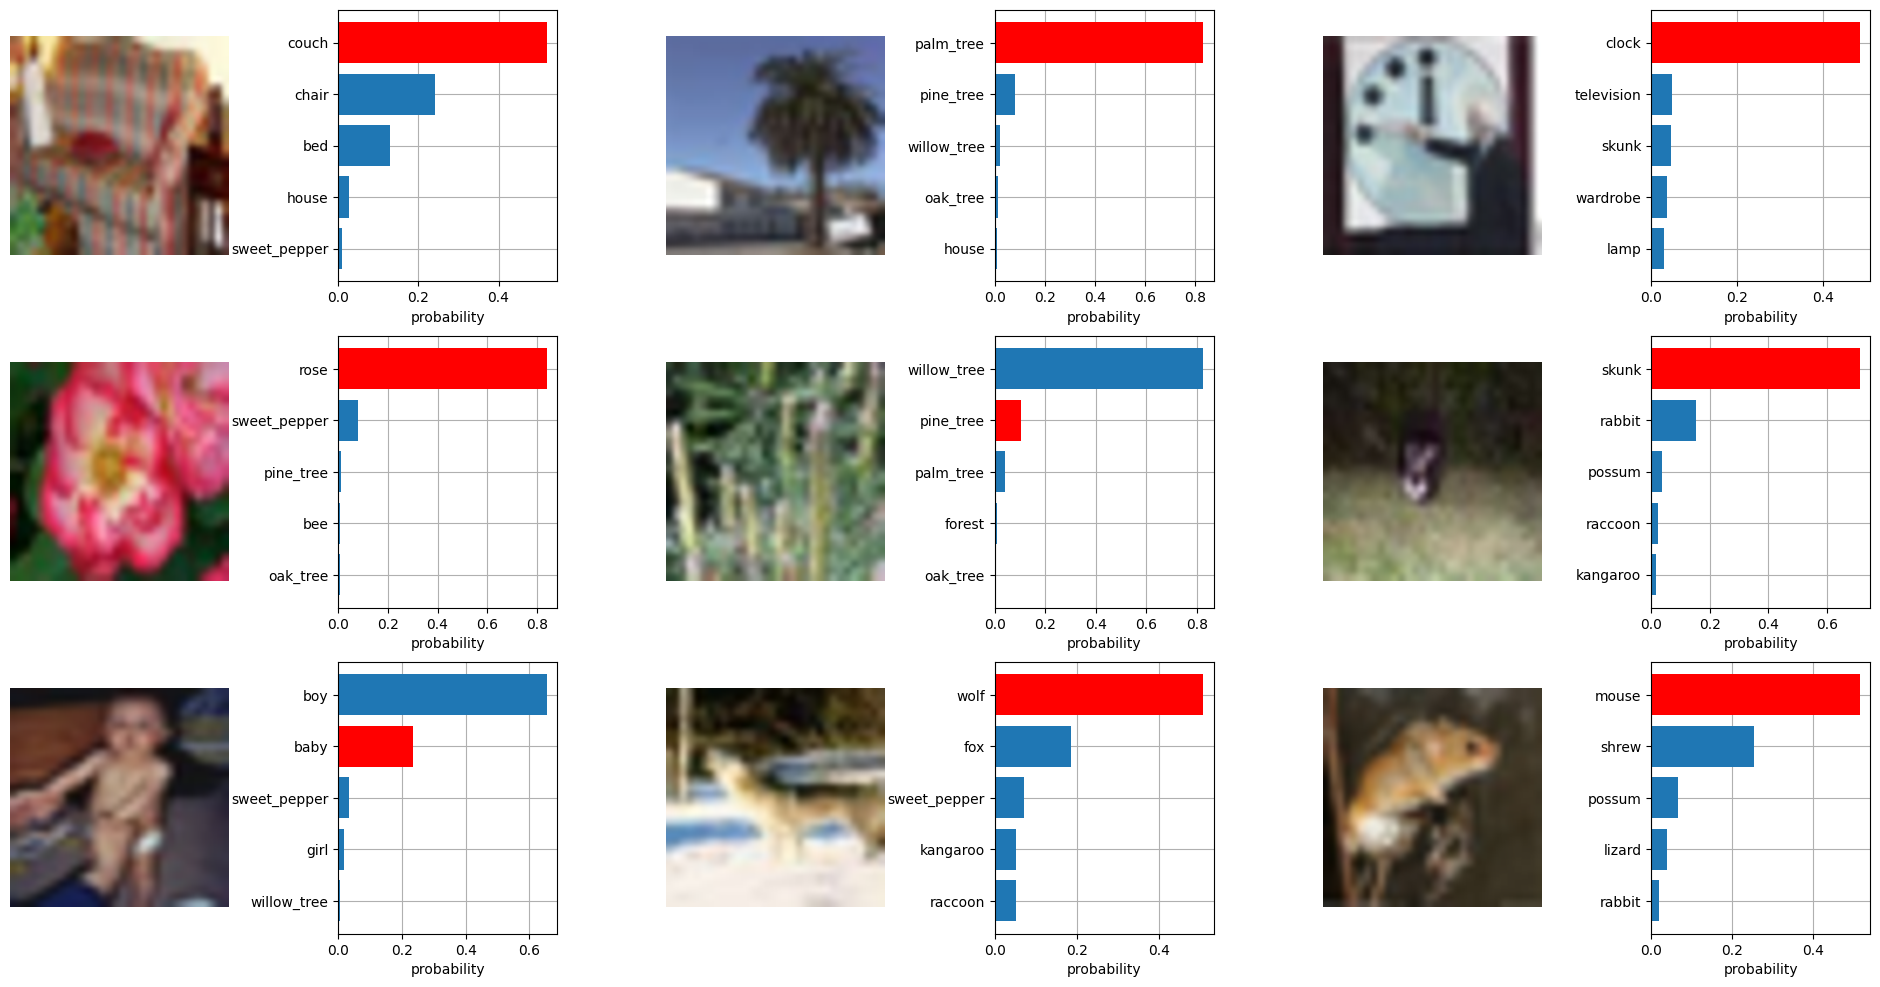

In [17]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
rows, cols = 3,3
plt.figure(figsize=(cols*8, rows*4))

for i, image in enumerate(image_input[:rows*cols]):
    plt.subplot(rows, cols * 2, 2 * i + 1)
    plt.imshow(denormalize(image.cpu()).permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(rows, cols * 2, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i].numpy()])
    if image_labels[i] in top_labels[i]:
        j = list(top_labels[i]).index(image_labels[i])
        plt.barh([j], [top_probs[i][j]], color='r')
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()